In [17]:
import pandas as pd
import sqlite3
import shlex
import numpy as np
import collections
from matplotlib import pyplot as pl
import matplotlib.cm as cm
from ast import literal_eval

%matplotlib inline

def auto_cast(s):
    try:
        return int(s)
    except ValueError:
        try:
            return float(s)
        except ValueError:
            if s.lower() in ["false", "true"]:
                try:
                    return bool(s)
                except ValueError:
                    pass
    return str(s)

def cmd_parser(s, sort=False, template_dict=None):
    if '.py' in s:
        s = s.split('.py')[1]
    res = [x.split('=') if '=' in x else x.split(' ') for x in s.split(' --')[1:]]
    res = dict([(x[0], auto_cast(x[1])) if len(x) == 2 else (x[0], True) for x in res])
    if template_dict is not None:
        template_dict.update(res)
        res = template_dict        
    if sort:
        return collections.OrderedDict(sorted(res.items()))
    else:
        return res

def get_optimal_df(leave_out, optimal_params, df):
    df_res = df
    print len(df_res)
    for param, val in optimal_params.iteritems():
        if not param == leave_out:
            df_res = df_res[df_res[param] == val]
            print len(df_res)
    return df_res

eval_metrics = [ 'score',
                 'train_loss',
                 'reg_loss',
                 'estimated_error',
                 'centroid_norm',
                 'emb_norm',
                 'k_score',
                 'svm_score'
               ]

In [18]:
# Establish DB connection
conn = sqlite3.connect("/usr/stud/plapp/runnn2/runnn_data")
df = pd.read_sql_query("select * from tasks where score > 0.3;", conn)  # where status is 'done' and changed > '2017-11-05'
conn.close()
print("Loaded %d rows." % len(df))

Loaded 1221 rows.


In [19]:
# Turn hyperparams into columns
hyperparams_df = df['params'].apply(literal_eval).apply(pd.Series)
params = hyperparams_df.columns.tolist()
df = df.join(hyperparams_df)

In [20]:
# Get list of datasets
datasets = [x for x in df.dataset.unique() if x == x]

In [21]:
print 'LEADERBOARD'
use_latest = 0
best_params_per_dataset = dict()
for dataset in datasets:
    ddf = df[df.dataset == dataset][-use_latest:]
    score_mean = ddf.score.mean() * 100
    score_std = ddf.score.std() * 100
    score_max = ddf.score.max() * 100
    score_max_taskid = ddf.ID_task[ddf.score.argmax()]
    print "%s:\t\t%.2f%%\t+/- %.2f (%d runs)\tbest: %.2f%% @ task %d" % (dataset[:6], score_mean, score_std, len(ddf), score_max, score_max_taskid)
    best_params_per_dataset[dataset] = df[df.ID_task == score_max_taskid][['ID_task'] + params].to_dict('list')

LEADERBOARD
mnist:		83.56%	+/- 19.32 (1117 runs)	best: 99.07% @ task 1812
svhn:		35.21%	+/- 3.63 (102 runs)	best: 46.33% @ task 3292
cifar_:		31.59%	+/- 1.00 (2 runs)	best: 32.29% @ task 4075


In [22]:
best_params_per_dataset['mnist']

{'ID_task': [1812],
 'architecture': ['resnet_mnist_model'],
 'beta1': [0.8],
 'beta2': [0.9],
 'centroid_momentum': [0],
 'cluster_association_weight': [1.0],
 'cluster_hardening_weight': [0.0],
 'dataset': ['mnist'],
 'decay_factor': [0.33],
 'decay_steps': [5000.0],
 'dropout_keep_prob': [0.9],
 'emb_size': [64],
 'eval_interval': [1000],
 'init_method': ['normal_center03'],
 'init_with_kmeans': [True],
 'l1_weight': [0.0],
 'learning_rate': [0.0008],
 'logdir': [None],
 'logit_entropy_weight': [0.0],
 'logit_weight': [0.5],
 'max_steps': [17000],
 'norm_target': [3.0],
 'norm_weight': [1e-05],
 'normalize_embeddings': [False],
 'normalize_input': [True],
 'num_augmented_samples': [3],
 'num_blocks': [3],
 'num_unlabeled_images': [0],
 'optimizer': ['adam'],
 'reg_association_weight': [1.0],
 'reg_decay_factor': [0.2],
 'reg_warmup_steps': [1000],
 'restore_checkpoint': [None],
 'rvisit_weight': [1],
 'rwalker_weight': [1.0],
 'scale_match_ab': [1],
 'shuffle_augmented_samples': [Fa

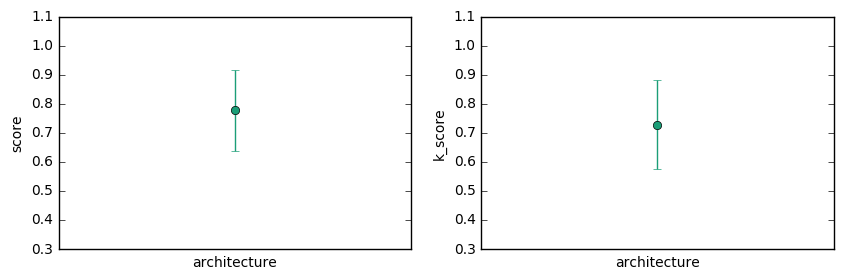

In [78]:
# Ablation study
not_plot = ['dataset', 'logdir', 'restore_checkpoint']
use_latest = 0  # how many runs to consider; 0=all
metrics_to_plot = ['score', 'k_score'] #eval_metrics
eval_against_optimal_params = False  # vary only param at hand, fix all others to optimum
needs_log_scale = ['logit_entropy_weight', 'trafo_weight', 'cluster_hardening_weight']

if eval_against_optimal_params:
    # Find optimal params
    optimal_params = dict()
    for p in params:
        if not p in not_plot:
            optimal_params[p] = df.pivot_table('score', columns=[p]).argmax()

for param in params[:1]:
    if param in not_plot:
        continue
        
    is_numeric = True
    try:
        df[param].astype(float)
    except ValueError:
        is_numeric = False
    
    if is_numeric:
        xstd = df[param].std()
        xmin = df[param].min()-xstd
        xmax = df[param].max()+xstd
    else:
        xlabels = [i for i in df[param].unique() if i==i]  # remove nans
        label_to_x = dict([(j,i) for (i,j) in enumerate(all_labels)])

    colors = iter(cm.Dark2(np.linspace(0, 1, len(datasets))))

    fig, axs = pl.subplots(1, len(metrics_to_plot), figsize=(10,3))
    for dataset in datasets: 
        ddf = df[df.dataset == dataset][-use_latest:]
        if eval_against_optimal_params:
            ddf = get_optimal_df(param, optimal_params, ddf)
        label = "%s (%d runs)" % (dataset, len(ddf))
        c = next(colors)
        
        xs = ddf[param].unique() 
        xs = [i for i in xs if i==i]  # remove nans
        
        if not is_numeric:
            xs_ = []
            for x in xs:
                xval = label_to_x[x]
                xs_.append(xval)
            xs = xs_
            xmin = -0.5
            xmax = len(xs) - 0.5
        
        for ax, metric_to_plot in enumerate(metrics_to_plot):
            ys = []
            for x in xs:
                if is_numeric:
                    y = ddf[ddf[param] == x][metric_to_plot].astype(float)
                else:
                    y = ddf[ddf[param] == xlabels[x]][metric_to_plot].astype(float)
                yerr = y.std()
                y = y.mean()
                ys.append(y)
                
                if param in needs_log_scale:
                    x += 1e-8
                axs[ax].errorbar(x, y, yerr=yerr, label=label, color=c, marker='o')

            if not xmin == xmax and not param in needs_log_scale:
                axs[ax].set_xlim((xmin, xmax))

            if not is_numeric:
                axs[ax].set_xticks(xs, minor=False)
                axs[ax].set_xticklabels(xlabels, minor=False, rotation=40, fontsize=8)
               
            if False and len(xs) > 1: 
                deg = np.clip(len(xs)-1, 1, 3)
                pf = np.poly1d(np.polyfit(xs, ys, deg))
                xp = np.linspace(np.min(xs), np.max(xs), 50)
                axs[ax].plot(xp, pf(xp), color=c)

            # fix legend
            handles, labels = axs[ax].get_legend_handles_labels()
            newLabels, newHandles = [], []
            for handle, label in zip(handles, labels):
                if label not in newLabels:
                    newLabels.append(label)
                    newHandles.append(handle)
            #axs[ax].legend(newHandles, newLabels, loc='best', fontsize=8)
            
            axs[ax].set_xlabel(param)
            axs[ax].set_ylabel(metric_to_plot)
            if param in needs_log_scale:
                axs[ax].set_xscale("log")
    pl.show()

In [83]:
xlabels

array(['resnet_mnist_model_d', 'resnet_mnist_model', 'resnet_cifar_model'], dtype=object)